# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [5]:
df = pd.read_csv("bikes_rent.csv")
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

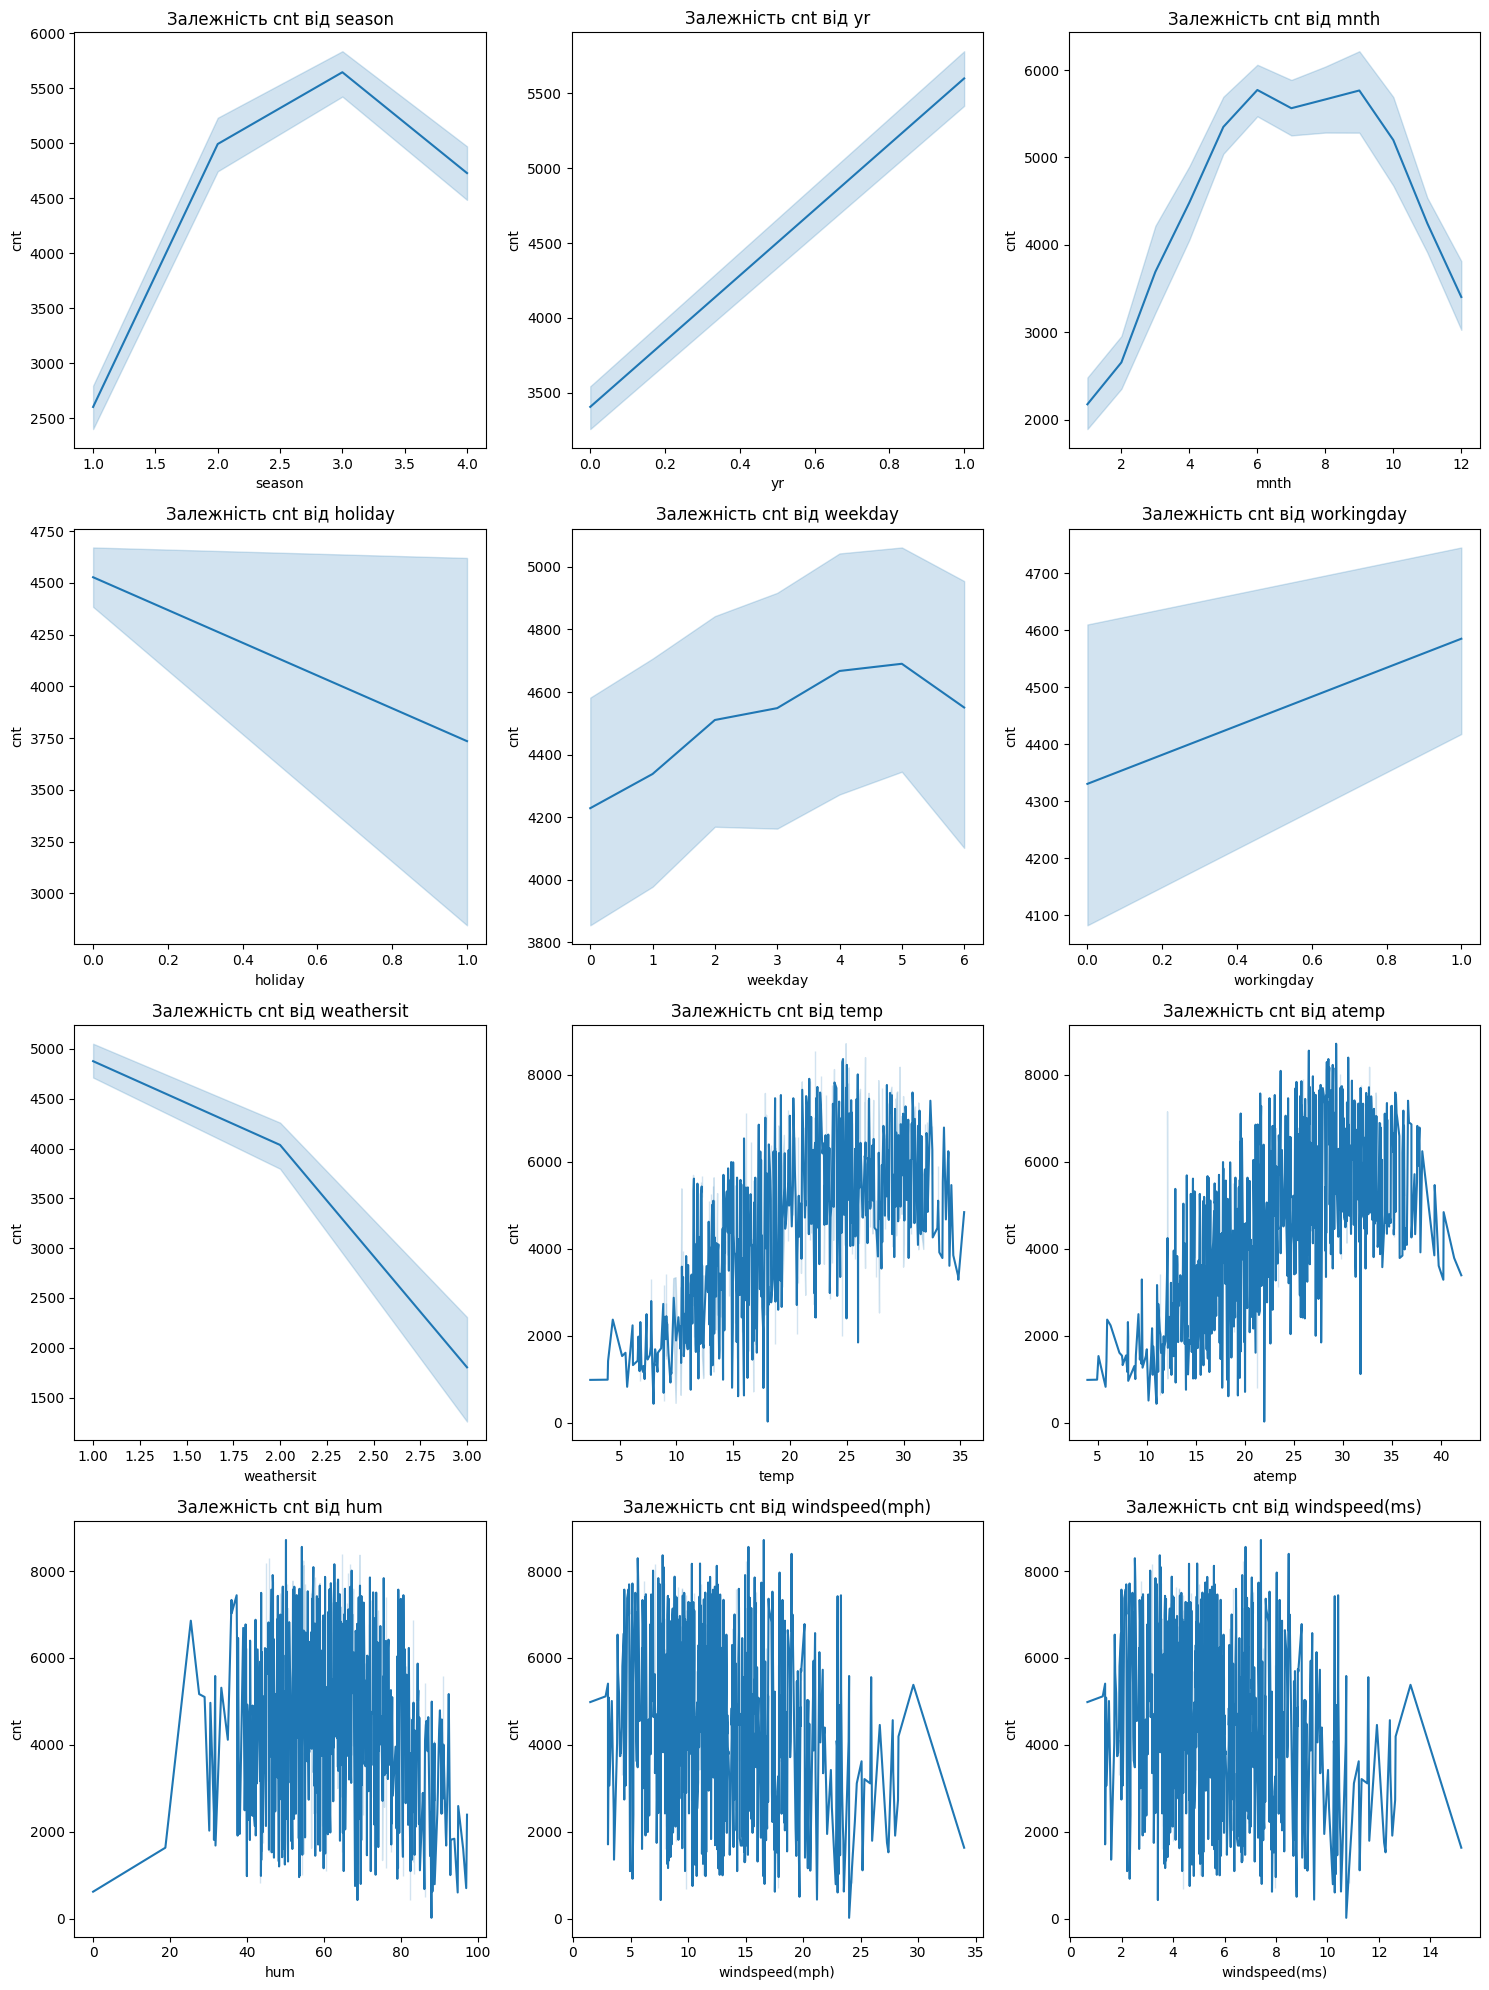

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 20))
features = ["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit", 
            "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)  
    sns.lineplot(x=feature, y="cnt", data=df)
    plt.title(f'Залежність cnt від {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')
plt.tight_layout()
plt.show()



__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?На графіку видно що найбільша кількість прокатів відбувалася з червня по вересень.
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.Holiday,workingday.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [71]:
correlations = df.corr(method='pearson')['cnt']
windspeed_ms = pd.DataFrame(df["windspeed(ms)"])
cnt = pd.DataFrame(df["cnt"])
correlations_2 = cnt.corrwith(windspeed_ms)
print(correlations)
print(correlations_2)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
Name: cnt, dtype: float64
cnt             NaN
windspeed(ms)   NaN
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [74]:
columns_of_interest = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
df_subset = df[columns_of_interest]
correlation_matrix = df_subset.corr()
print(correlation_matrix)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [76]:
for row in df:
    print(df[row].mean())

2.496580027359781
0.5006839945280438
6.519835841313269
0.028727770177838577
2.997264021887825
0.6839945280437757
1.3953488372093024
20.31077632886457
23.717699432284544
62.78940629274965
12.762576179069768
5.705219570438215
4504.3488372093025


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [78]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [79]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [ ]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [83]:
import pandas as pd
from sklearn.linear_model import LinearRegression
df = pd.read_csv("bikes_rent.csv") 
X = df[["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit", 
            "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]] 
y = df['cnt']  
regressor = LinearRegression()
regressor.fit(X, y)
weights = regressor.coef_
feature_names = X.columns
for feature, weight in zip(feature_names, weights):
    print(f'{feature}: {weight:.4f}')


season: 514.2755
yr: 2043.9359
mnth: -40.9630
holiday: -519.3879
weekday: 68.4955
workingday: 121.2915
weathersit: -606.4532
temp: 48.9954
atemp: 71.9149
hum: -10.2306
windspeed(mph): 2401064826724.1289
windspeed(ms): -5371182017466.6768


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [85]:
from sklearn.linear_model import Lasso
X = df[["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit", 
        "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]]
y = df['cnt']
lasso_regressor = Lasso(alpha=0.1)
lasso_regressor.fit(X, y)
weights = lasso_regressor.coef_
feature_names = X.columns
for feature, weight in zip(feature_names, weights):
    print(f'{feature}: {weight:.4f}')


season: 509.4528
yr: 2040.2562
mnth: -38.8894
holiday: -515.5581
weekday: 69.0498
workingday: 120.1660
weathersit: -610.3450
temp: 49.6742
atemp: 71.3096
hum: -10.2050
windspeed(mph): -38.1895
windspeed(ms): -0.0000


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [86]:
from sklearn.linear_model import Ridge
X = df[["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit", 
        "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]]
y = df['cnt']
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X, y)
weights = ridge_regressor.coef_
feature_names = X.columns
for feature, weight in zip(feature_names, weights):
    print(f'{feature}: {weight:.4f}')


season: 507.8019
yr: 2029.0891
mnth: -38.4709
holiday: -493.2780
weekday: 69.1140
workingday: 121.5244
weathersit: -605.2056
temp: 49.3168
atemp: 71.7860
hum: -10.3834
windspeed(mph): -31.9355
windspeed(ms): -14.2760


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [87]:
from sklearn.linear_model import Lasso, Ridge
alphas = [0.1, 1.0, 10.0, 100.0]
X = df[["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit", 
        "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]]
y = df['cnt']
coefs_lasso = []
coefs_ridge = []
for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
print("Lasso coefficients:\n", coefs_lasso)
print("Ridge coefficients:\n", coefs_ridge)


Lasso coefficients:
 [[ 509.45281498 2040.25621742  -38.88943663 -515.55808989   69.04981422
   120.16602822 -610.34503326   49.67420564   71.3095701   -10.20502104
   -38.18953571   -0.        ]
 [ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
   118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
   -38.34106761   -0.        ]
 [ 477.32591467 1996.24931816  -29.92697086 -171.77719511   68.25910797
   101.79300668 -545.45447186   51.34556518   71.49410924  -11.91744494
   -39.30755407   -0.        ]
 [ 297.07442417 1608.4605901     9.23821408   -0.           37.80311401
     0.           -4.85009184   37.3541199    95.92588228  -26.3545609
   -48.10976518   -0.        ]]
Ridge coefficients:
 [[ 5.09578216e+02  2.03953571e+03 -3.89289154e+01 -5.16297624e+02
   6.90682759e+01  1.20484993e+02 -6.10403641e+02  4.94679667e+01
   7.14984922e+01 -1.02082332e+01 -3.18270943e+01 -1.42275807e+01]
 [ 5.07801882e+02  2.02908905e+03 -3.84708973e+01 -4.9327801

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

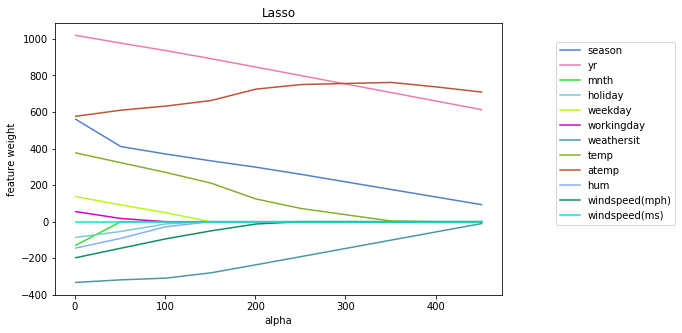

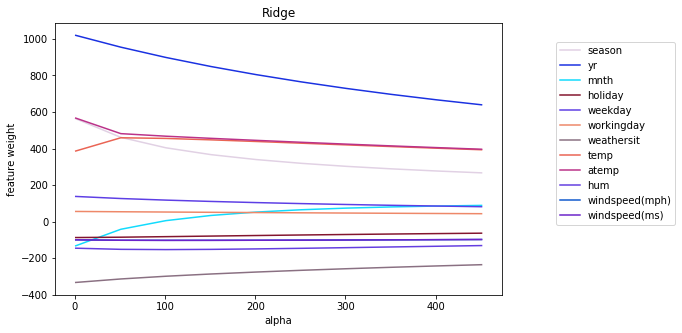

In [ ]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?
1.Lasso є агресивнішим у зменшенні ваг, оскільки він може встановлювати ваги деяких ознак точно в нуль. Це дозволяє Lasso фактично виключати ознаки, які не впливають на модель, тоді як Ridge зменшує ваги всіх ознак, але не зануляє їх. Вплив Lasso при одному й тому самому alpha є сильнішим у порівнянні з Ridge, особливо для менш інформативних ознак.
2. Якщо зробити значення alpha дуже великим, ваги для більшості (якщо не всіх) ознак у Lasso будуть встановлені в нуль. Це відбувається тому, що великий коефіцієнт регуляризації накладає сильне обмеження на суму абсолютних значень ваг, що примушує модель зануляти всі коефіцієнти, крім найважливіших. Це призводить до занадто жорсткої регуляризації, через яку модель стає надмірно спрощеною і практично не використовує вхідні ознаки.
3. Lasso може виключити одну з ознак windspeed навіть при малих значеннях alpha > 0, якщо одна з ознак є надлишковою або малозначущою. Оскільки дві ознаки (windspeed(mph) і windspeed(ms)) можуть бути сильно корельованими (бо представляють одну й ту ж характеристику в різних одиницях виміру), Lasso, швидше за все, занулить одну з них при будь-якому ненульовому значенні alpha.
Ridge, навпаки, не зануляє ваги повністю. Він просто зменшує їх пропорційно, і навіть при великих значеннях alpha коефіцієнти будуть малими, але не рівними нулю. Тому Ridge не виключатиме ознаку.
4.Для відбору неінформативних ознак краще підходить Lasso, оскільки він здатний зануляти ваги ознак, які не впливають на модель. Це дозволяє легко ідентифікувати ознаки, які не додають корисної інформації.
Ridge не підходить для відбору ознак, оскільки він просто зменшує ваги, але не зануляє їх повністю, навіть для неінформативних ознак.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [ ]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

C:\Users\kybav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192502.016074121, tolerance: 187538.32612649575
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kybav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175792.82306826115, tolerance: 173313.10019722223
  model = cd_fast.enet_coordinate_descent_gram(


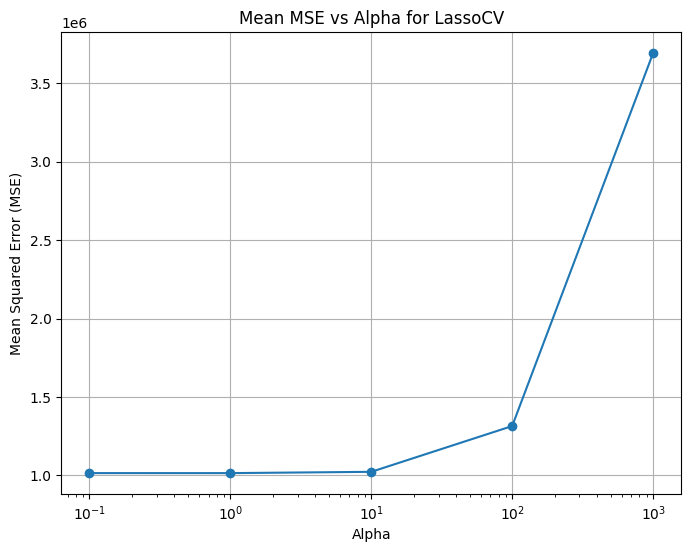

In [88]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
def create_plot(alphas, mse_means):
    plt.figure(figsize=(8, 6))
    plt.plot(alphas, mse_means, marker='o')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Mean MSE vs Alpha for LassoCV')
    plt.grid(True)
    plt.show()
X = df[["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit", 
        "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]]
y = df['cnt']
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0]  
lasso_cv = LassoCV(alphas=alphas, cv=5)   
lasso_cv.fit(X, y)
predictions = cross_val_predict(lasso_cv, X, y, cv=5)
mse_means = np.mean(lasso_cv.mse_path_, axis=1)
create_plot(lasso_cv.alphas_, mse_means)


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas corresponding to minimum MSE for each fold: [ 10.    0.1 100.    0.1   0.1]


C:\Users\kybav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192502.016074121, tolerance: 187538.32612649575
  model = cd_fast.enet_coordinate_descent_gram(


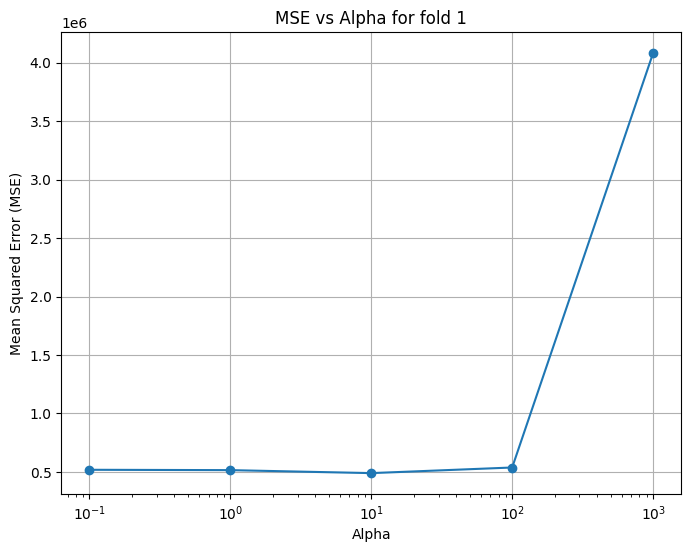

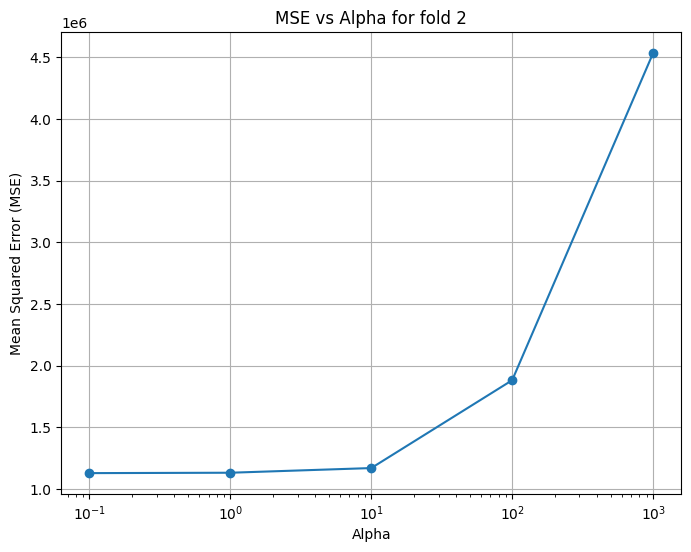

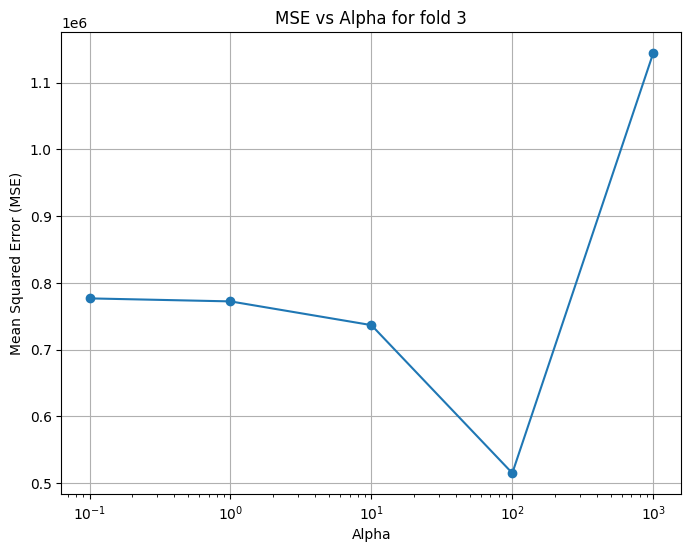

In [90]:
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0] 
lasso_cv = LassoCV(alphas=alphas, cv=5)   
lasso_cv.fit(X, y)
min_mse_alphas = lasso_cv.alphas_[np.argmin(lasso_cv.mse_path_, axis=0)]
print("Alphas corresponding to minimum MSE for each fold:", min_mse_alphas)
def plot_mse_columns(mse_path, alphas, col_idx, fold_number):
    plt.figure(figsize=(8, 6))
    plt.plot(alphas, mse_path[:, col_idx], marker='o')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'MSE vs Alpha for fold {fold_number}')
    plt.grid(True)
    plt.show()
for i in range(3):
    plot_mse_columns(lasso_cv.mse_path_, lasso_cv.alphas_, i, i+1)


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

Наприклад, для ознак, таких як temp (температура) або atemp (сприйняття температури), логічно очікувати лінійну залежність — чим вища температура, тим більше людей захочуть взяти велосипеди (до певної межі).
Логічно припустити, що зростаючі значення деяких ознак можуть збільшити кількість користувачів велосипедів:
Температура (temp, atemp): За хороших погодних умов більше людей захоче взяти велосипеди. Це узгоджується із здоровим глуздом.
Сезон (season): У тепліші місяці (весна, літо) більше людей їздить на велосипедах, що також є логічним припущенням.
Робочий день (workingday): Якщо це робочий день, логічно, що більше людей може користуватися велосипедами для поїздок на роботу.
Таким чином, потрібно підтвердити ці припущення візуалізаціями й аналізом отриманих коефіцієнтів. Залежності можуть відрізнятися для різних ознак, але ті ознаки, які отримують високі позитивні коефіцієнти, зазвичай мають лінійну або майже лінійну позитивну залежність із цільовою змінною cnt.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

Наприклад, ознаки на кшталт weathersit (стан погоди) можуть мати спадну залежність — чим гірша погода, тим менше людей захочуть взяти велосипед.
Погода (weathersit): Логічно очікувати, що зі збільшенням значення цієї ознаки (гірша погода), кількість людей, які захочуть взяти велосипеди, буде зменшуватися. Це узгоджується із здоровим глуздом — у погану погоду (дощ, сніг) менше людей користується велосипедами.
Вологість (hum): Якщо значення вологості високе, це може негативно вплинути на бажання людей брати велосипеди. Велика вологість може бути неприємною для їзди.
Швидкість вітру (windspeed): Висока швидкість вітру ускладнює поїздку на велосипеді, тому це також може призвести до зменшення кількості бажаючих взяти велосипед.
Таким чином, з огляду на візуалізації і здоровий глузд, можна зробити висновок, що для таких ознак, як погода, вологість, швидкість вітру, справді існує спадна залежність — чим більше значення цих ознак, тим менше людей захочуть взяти велосипеди.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

Якщо модель LassoCV занулила або зробила коефіцієнти дуже малими для певних ознак, це може свідчити про те, що:
Ознака не є значущою для прогнозування цільової змінної (cnt), оскільки її внесок у модель є мінімальним.
Кореляція з іншими ознаками: Якщо ознака сильно корелює з іншою ознакою, Lasso може занулити одну з корельованих ознак. Наприклад, це може статися з двома ознаками, які представляють одну й ту ж інформацію в різних одиницях виміру.
Чому модель виключила ці ознаки?
Можливо, це сталося через одну або кілька з наступних причин:
Низька варіативність: Якщо ознака має малу мінливість (тобто майже постійна), вона мало впливає на модель.
Кореляція з іншими ознаками: Якщо ознака дуже схожа на іншу, модель може занулити одну з них, щоб уникнути надмірної мультиколінеарності.
Недостатня кореляція з cnt: Якщо залежність між ознакою і кількістю взятих велосипедів слабка або нелінійна, модель може вважати ознаку неінформативною.
Чи впливають ці ознаки на попит на велосипеди?
Щоб відповісти на це питання, слід знову подивитися на графіки залежностей між цими ознаками та cnt (якщо такі візуалізації були раніше побудовані). Якщо на графіках не спостерігається явної лінійної або сильної нелінійної залежності між ознакою і попитом на велосипеди, то модель правильно виключила їх як малозначущі.
Приклад: Якщо ознака, як-от holiday (чи це святковий день), має дуже малий коефіцієнт, це може свідчити про те, що кількість взятих велосипедів не сильно змінюється залежно від того, святковий день чи ні.
Висновок:
Ознаки з коефіцієнтами близькими до нуля не обов'язково не впливають зовсім на попит на велосипеди, але їх вплив може бути настільки малим або косвенно залежним, що модель вирішила їх не враховувати, оскільки вони не покращують прогнозування cnt.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.